## Comparing CEDS and SNEII inventories in OsloCTM3
### Aerosol plots

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
#import xesmf as xe
from matplotlib import rcParams
import pandas as pd
import regionmask
import geopandas as gp
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
import matplotlib

ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db


In [2]:
#define file locations
file_loc1 = '/div/pdo/mariantl/QUISARC/osloctm3_newIndEmis/dta2nc/'

#***change filename here***
filename1 = 'OsloCTM3_aero_load3d_monthly_2018_CEDS21.nc'
filename2 = 'OsloCTM3_aero_load3d_monthly_2018_CEDS21_SNEII.nc'

outfile = '/div/nac/users/zofias/plots/SNEII/'

In [3]:
# import shape file for states
zipfile = "/div/no-backup/users/zofias/India_State_Boundary.shp"
states = gp.read_file(zipfile)

In [4]:
#states

In [5]:
rcParams['font.size'] = 16

time_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] #[1,2,3,4,5,6,7,8,9,10,11,12]
month_labs = ['J','F','M','A','M','J','J','A','S','O','N','D']

### Import data

In [6]:
#import data
ds_ceds = xr.open_dataset(f'{file_loc1}{filename1}')
ds_sneii = xr.open_dataset(f'{file_loc1}{filename2}')

#calculate difference
ds_diff = ds_sneii - ds_ceds

In [7]:
ds_ceds

<xarray.Dataset>
Dimensions:    (lat: 80, lon: 160, lev: 60, time: 12)
Coordinates:
  * lat        (lat) float32 -88.75 -86.37 -84.12 -81.87 ... 84.12 86.37 88.75
  * lon        (lon) float32 0.5625 2.812 5.062 7.312 ... 353.8 356.1 358.3
  * lev        (lev) float32 998.8 995.9 991.5 985.3 ... 0.5104 0.2921 0.11
Dimensions without coordinates: time
Data variables: (12/16)
    area       (lat, lon) float32 ...
    BC         (time, lev, lat, lon) float32 ...
    BCBB       (time, lev, lat, lon) float32 ...
    BCFFBF     (time, lev, lat, lon) float32 ...
    NO3FIN     (time, lev, lat, lon) float32 ...
    NO3CRS     (time, lev, lat, lon) float32 ...
    ...         ...
    SOA        (time, lev, lat, lon) float32 ...
    NH4FIN     (time, lev, lat, lon) float32 ...
    NH4CRS     (time, lev, lat, lon) float32 ...
    SeaSalt    (time, lev, lat, lon) float32 ...
    Dust       (time, lev, lat, lon) float32 ...
    POAmarine  (time, lev, lat, lon) float32 ...
Attributes:
    Comment:        Concentrations from OsloCTM3
    contact:        m.t.lund@cicero.uio.no
    creation_date:  2022-10-10

In [8]:
#make mask for regions
lon = np.arange(-180, 180)
lat = np.arange(-90, 90)

mask = regionmask.mask_geopandas(states, lon, lat)

/tmp/ipykernel_2283414/840373041.py:5: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  mask = regionmask.mask_geopandas(states, lon, lat)


In [9]:
#import area dataset for area weighted mean
#ds_area = xr.open_dataset('/div/nac/users/zofias/ACACIA/OsloCTM3_80_160_areacella.nc')
ds_delta_z = xr.open_dataset('/div/nac/users/zofias/ACACIA/OsloCTM3_80_160_delta_z.nc')

box_area = ds_ceds["area"]
delta_z = ds_delta_z["delta_z"]*-1

ds_landmask = xr.open_dataset('/div/no-backup/users/zofias/landsea_OsloCTMres.nc')

ds_landmask['lat'] = ds_sneii.lat
ds_landmask['lon'] = ds_sneii.lon


weights_lat_lon_3d = np.array(60*[box_area.data]) # weights for 12 months
#weights_lat_lon_2d = box_area.data

In [10]:
#obs station labels and locations
station_lat_lons = np.array([[77.2,28.68],[76.37,30.35],[73.72,24.58],[79.97,23.15],[73.8,18.53],[78.4,17.52],[91.65,26.15],[80.13,13.03]])
station_labs = ['Delhi','Patiala','Udaipur','Jabalpur','Pune','Hyderabad','Guwahati','Chennai']

#city labels and locations
city_names = ['Mumbai','Delhi','Kolkata','Chennai','Bengalūru','Hyderabad']
city_lat_lons = np.array([[72.836447, 18.987807],[77.231495, 28.651952], [88.363044, 22.562627],[80.248357, 13.084622],[77.587106, 12.977063],[78.456355, 17.384052]])

### Calculations: averaging, surface conc, column

In [11]:
calcs = {
    "CEDS": xr.Dataset(),
    "diff": xr.Dataset(),
    "SNEII": xr.Dataset()
}

models = {
    "CEDS": ds_ceds,
    "diff": ds_diff,
    "SNEII": ds_sneii
}

model_list = ["CEDS", "diff", "SNEII"]

In [12]:
#define constants
mr_o3 = 48.
mr_air = 28.97
n_a = 6.022e23

In [13]:
#select surface concs
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")

    exp_calc["BC_surf"] = (
        exp_ukca.BC 
        .isel(lev = 0)
        *1e9 #convert to  ug m-3
    )
    exp_calc["NO3_surf"] = (
        (exp_ukca.NO3CRS + exp_ukca.NO3FIN)
        .isel(lev = 0)
        *1e9 #convert to  ug m-3
    )
    exp_calc["SO4_surf"] = (
        exp_ukca.SO4 
        .isel(lev = 0)
        *1e9 #convert to  ug m-3
    )
    exp_calc["OA_surf"] = (
        (exp_ukca.POA + exp_ukca.SOA)
        .isel(lev = 0)
        *1e9 #convert to  ug m-3
    )
    exp_calc["NH4_surf"] = (
        (exp_ukca.NH4CRS + exp_ukca.NH4FIN)
        .isel(lev = 0)
        *1e9 #convert to  ug m-3
    )
    exp_calc["SOA_surf"] = (
        exp_ukca.SOA 
        .isel(lev = 0)
        *1e9 #convert to  ug m-3
    )

In [14]:
#land mask
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["BC_land_masked"] = (
        exp_calc.BC_surf.where(ds_landmask.LSMASK > 0.9)
        .load()
    )
    exp_calc["NO3_land_masked"] = (
        exp_calc.NO3_surf.where(ds_landmask.LSMASK > 0.9)
        .load()
    )
    exp_calc["SO4_land_masked"] = (
        exp_calc.SO4_surf.where(ds_landmask.LSMASK > 0.9)
        .load()
    )
    exp_calc["POA_land_masked"] = (
        exp_calc.OA_surf.where(ds_landmask.LSMASK > 0.9)
        .load()
    )
    exp_calc["NH4_land_masked"] = (
        exp_calc.NH4_surf.where(ds_landmask.LSMASK > 0.9)
        .load()
    )
    exp_calc["SOA_land_masked"] = (
        exp_calc.SOA_surf.where(ds_landmask.LSMASK > 0.9)
        .load()
    )

In [15]:
#select surface conc and calculate mean
for exp in model_list:
    exp_calc = calcs[exp]
    
    exp_calc["BC_india_land_mean"] = (
        exp_calc["BC_land_masked"]
        .sel(lon=slice(65, 95), lat=slice(6, 35))
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )
    exp_calc["NO3_india_land_mean"] = (
        exp_calc["NO3_land_masked"]
        .sel(lon=slice(65, 95), lat=slice(6, 35))
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )
    exp_calc["SO4_india_land_mean"] = (
        exp_calc["SO4_land_masked"]
        .sel(lon=slice(65, 95), lat=slice(6, 35))
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )
    exp_calc["POA_india_land_mean"] = (
        exp_calc["POA_land_masked"]
        .sel(lon=slice(65, 95), lat=slice(6, 35))
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )
    exp_calc["NH4_india_land_mean"] = (
        exp_calc["NH4_land_masked"]
        .sel(lon=slice(65, 95), lat=slice(6, 35))
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )
    exp_calc["SOA_india_land_mean"] = (
        exp_calc["SOA_land_masked"]
        .sel(lon=slice(65, 95), lat=slice(6, 35))
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )

In [16]:
calcs['SNEII']

<xarray.Dataset>
Dimensions:              (lat: 80, lon: 160, time: 12)
Coordinates:
  * lat                  (lat) float32 -88.75 -86.37 -84.12 ... 86.37 88.75
  * lon                  (lon) float32 0.5625 2.812 5.062 ... 353.8 356.1 358.3
    lev                  float32 998.8
Dimensions without coordinates: time
Data variables: (12/18)
    BC_surf              (time, lat, lon) float32 9.153e-05 ... 0.001039
    NO3_surf             (time, lat, lon) float32 0.1191 0.1199 ... 0.3557
    SO4_surf             (time, lat, lon) float32 0.3376 0.3388 ... 0.4346
    OA_surf              (time, lat, lon) float32 0.0093 0.009399 ... 0.01883
    NH4_surf             (time, lat, lon) float32 0.0008792 0.0008867 ... 0.1979
    SOA_surf             (time, lat, lon) float32 0.008448 0.008545 ... 0.01534
    ...                   ...
    BC_india_land_mean   (time) float32 5.654 4.092 3.602 ... 3.732 4.853 6.188
    NO3_india_land_mean  (time) float32 5.658 3.057 2.427 ... 2.181 3.041 6.391
    SO4_india_land_mean  (time) float32 3.717 3.348 3.344 ... 4.042 3.915 3.831
    POA_india_land_mean  (time) float32 22.18 14.56 14.72 ... 14.87 19.53 22.89
    NH4_india_land_mean  (time) float32 2.774 1.822 1.527 ... 1.845 2.174 3.056
    SOA_india_land_mean  (time) float32 1.132 1.146 1.955 ... 1.493 1.315 1.126

### Plots

In [17]:
calcs['SNEII'].BC_india_land_mean.mean()

<xarray.DataArray 'BC_india_land_mean' ()>
array(3.1611617, dtype=float32)
Coordinates:
    lev      float32 998.8

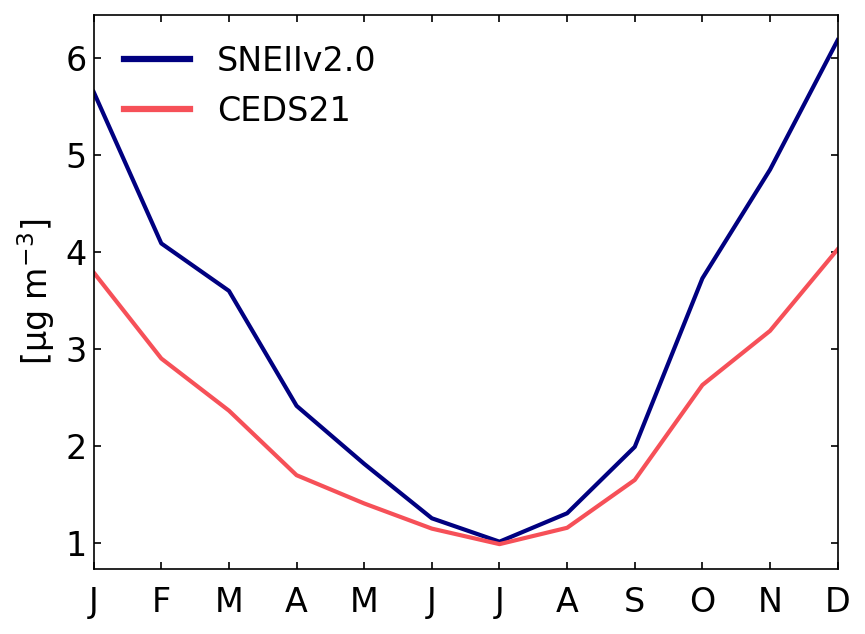

In [18]:
fig = plt.figure(dpi=150)
ax = plt.axes()

calcs['SNEII'].BC_india_land_mean.plot(label = 'SNEIIv2.0', c= (0,0,128/255),linewidth=2)
calcs['CEDS'].BC_india_land_mean.plot(label = 'CEDS21', c=(246/255,80/255,88/255),linewidth=2)


#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)

# chart formatting
ax.set_xlim(0,11)
ax.set_xticks(calcs['CEDS'].BC_india_land_mean.time.data,month_labs)
plt.title('')
ax.set_xlabel('')
ax.set_ylabel(r"[μg m$^{{-3}}$]")
leg = plt.legend(frameon=False,loc=2)
#ax.set_yticks(minor=True)
ax.xaxis.set_tick_params(direction='in', which='both',top=True,pad=8)
ax.yaxis.set_tick_params(direction='in', which='both',right=True)

ax.yaxis.set_minor_locator(MultipleLocator(1))
#ax.tick_params(axis='y', which='minor', bottom=False)


for legobj in leg.legendHandles:
    legobj.set_linewidth(3)

#plt.gca().set_aspect(0.45)
#plt.savefig(f'{outfile}SNEII_CEDS_o3_surface_india_mean_land_masked_clim.pdf',format='pdf',bbox_inches='tight')


In [19]:
cmap_ol_pu_bk = LinearSegmentedColormap.from_list('Random gradient 442', (
    # Edit this gradient at https://eltos.github.io/gradient/#Random%20gradient%20442=0:FFFFFF-25:B6B610-60:7A7AF3-100:000000
    (0.000, (1.000, 1.000, 1.000)),
    (0.250, (0.714, 0.714, 0.063)),
    (0.600, (0.478, 0.478, 0.953)),
    (1.000, (0.000, 0.000, 0.000))))

Text(0.5, 1.0, '')

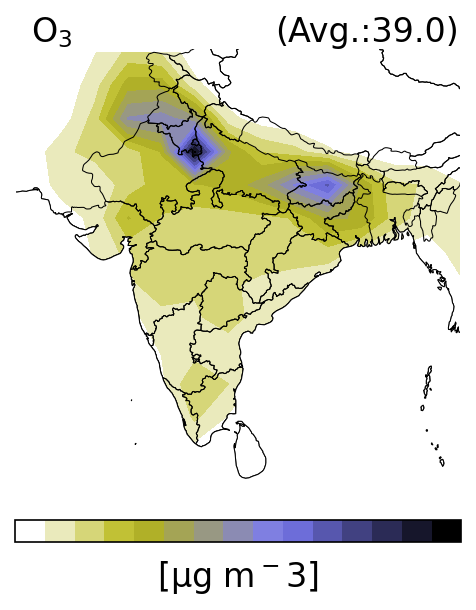

In [20]:
fig, ax = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = calcs['SNEII'].BC_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(cmap=cmap_ol_pu_bk,
    #vmax=65, vmin=25,
    levels=21, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f"[μg m$^{-3}$]",location='bottom',pad= 0.05,shrink=0.6,ticks=np.arange(25,66,10))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')
plt.text(66,35.5,f'O$_3$')
plt.text(82.5,35.5,f'(Avg.:39.0)')
#plt.scatter(city_lat_lons[:,0],city_lat_lons[:,1],marker='d',c='deeppink',zorder=10)
ax.axis("off") #remove frame around figure
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
plt.title('')
#plt.savefig(f'{outfile}SNEII_o3_surface_map_land_masked.pdf',format='pdf',bbox_inches='tight')

Text(0.5, 1.0, '')

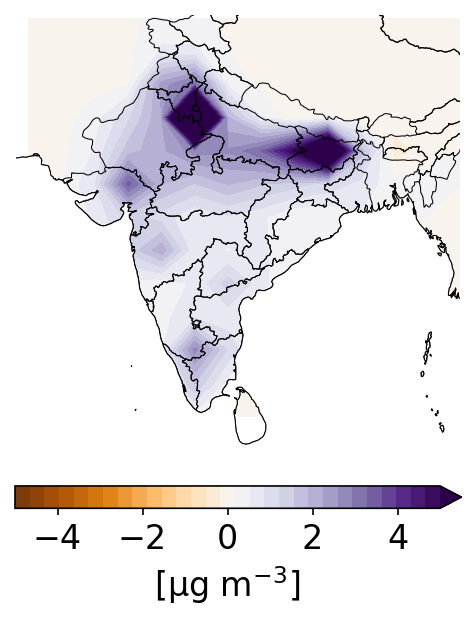

In [21]:
fig, ax = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = calcs['diff'].BC_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(cmap="PuOr",
    vmax=5, vmin=-5,
    levels=30, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= r"[μg m$^{{-3}}$]",location='bottom',pad= 0.05,shrink=0.6,ticks=np.arange(-4,5,2))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')

ax.axis("off") #remove frame around figure
#plt.savefig(f'{outfile}SNEII_CEDS_diff_o3_surface_map_land_masked.pdf',format='pdf',bbox_inches='tight')
plt.title("")

AttributeError: 'Dataset' object has no attribute 'O3_surf'

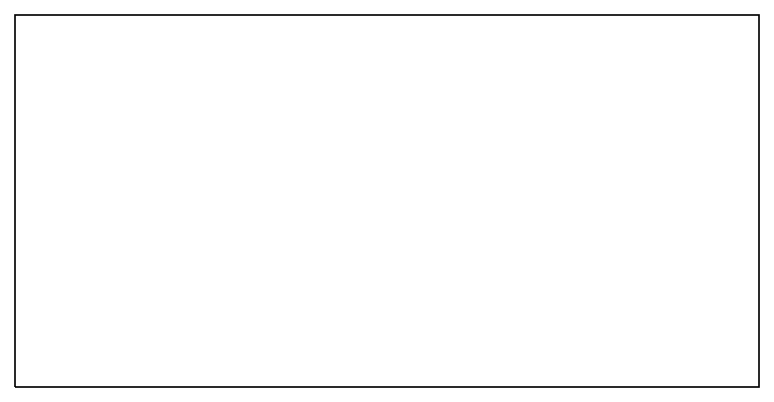

In [22]:
fig, ax = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = calcs['SNEII'].O3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.pcolormesh(cmap=cmap_ol_pu_bk,
    vmax=65, vmin=25,levels=21, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[ppb]',location='bottom',pad= 0.05,shrink=0.6,ticks=np.arange(25,66,10))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')
plt.text(66,35.5,f'O$_3$')
plt.text(82.5,35.5,f'(Avg.:39.0)')
plt.scatter(station_lat_lons[:,0],station_lat_lons[:,1],marker='o',facecolors='none',edgecolors='deeppink',zorder=10,s=8)
ax.axis("off") #remove frame around figure
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
#plt.title(f"SNEII - CEDS")

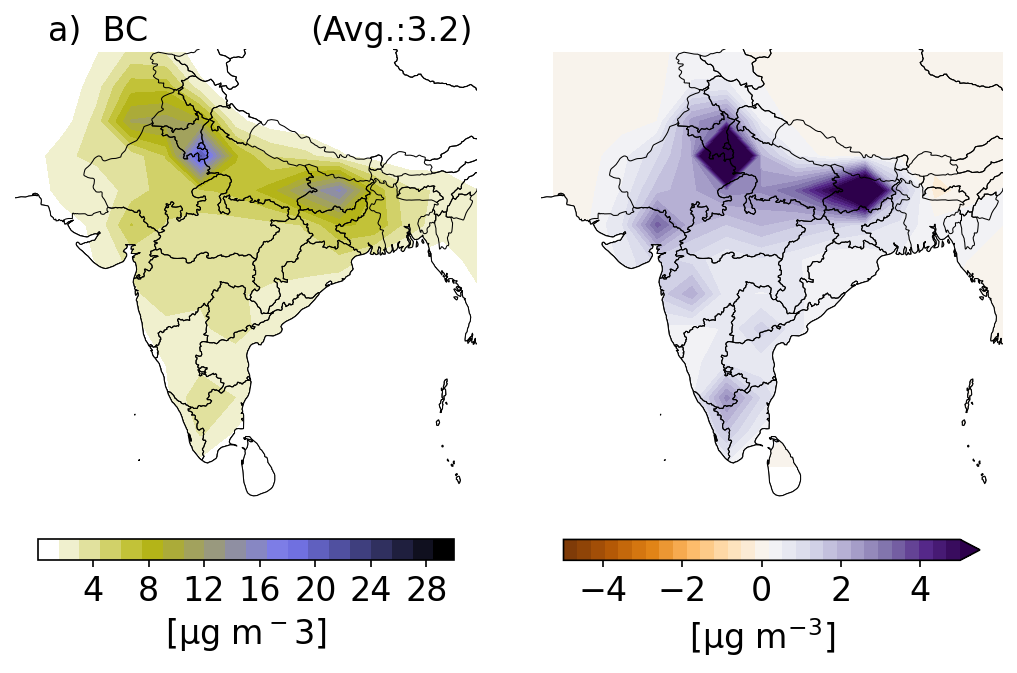

In [23]:

fig, axs = plt.subplots(1, 2, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(9, 5))

# Plot 1: SNEII surface map
ax = axs[0]
fg1 = calcs['SNEII'].BC_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=30, 
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=f"[μg m$^{-3}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 30,4))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())

ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

plt.text(33,35.5,f'a)  BC')
plt.text(50,35.5,f"(Avg.:{calcs['SNEII'].BC_india_land_mean.mean():.1f})")

# Plot 2: Difference map
ax = axs[1]
fg2 = calcs['diff'].BC_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=5, vmin=-5, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-4, 5, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


plt.subplots_adjust(wspace=0.01)



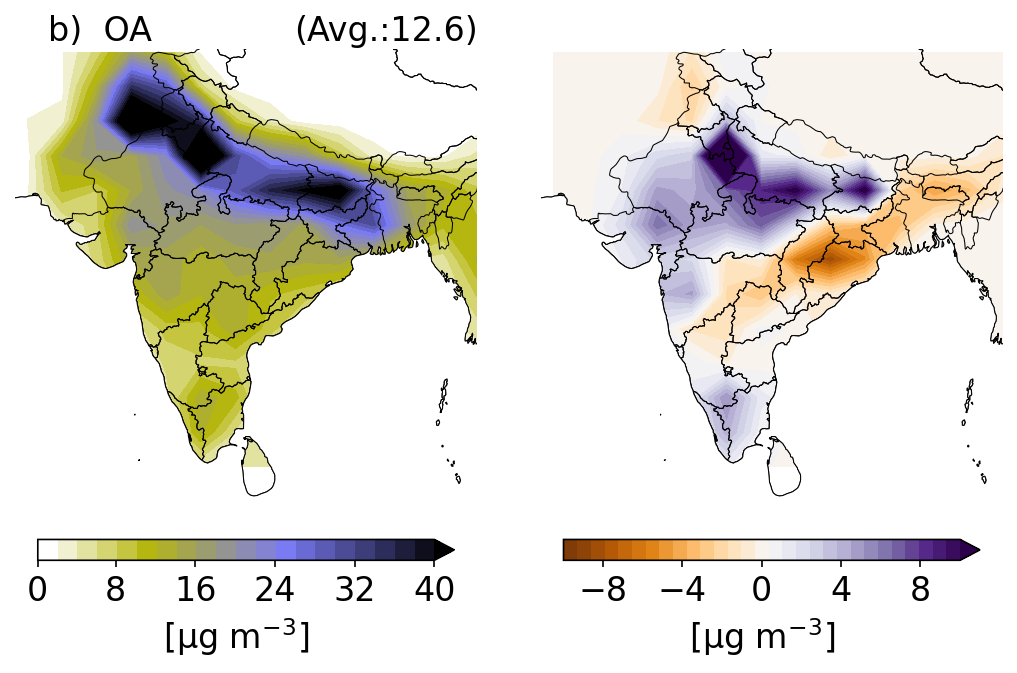

In [24]:

fig, axs = plt.subplots(1, 2, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(9, 5))

# Plot 1: SNEII surface map
ax = axs[0]
fg1 = calcs['SNEII'].OA_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=40, 
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 41,8))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())

ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

plt.text(33,35.5,f'b)  OA')
plt.text(49,35.5,f"(Avg.:{calcs['SNEII'].POA_india_land_mean.mean():.1f})")

# Plot 2: Difference map
ax = axs[1]
fg2 = calcs['diff'].OA_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=10, vmin=-10, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-8, 11, 4))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


plt.subplots_adjust(wspace=0.01)
# Final adjustments
#plt.tight_layout()
#plt.show()

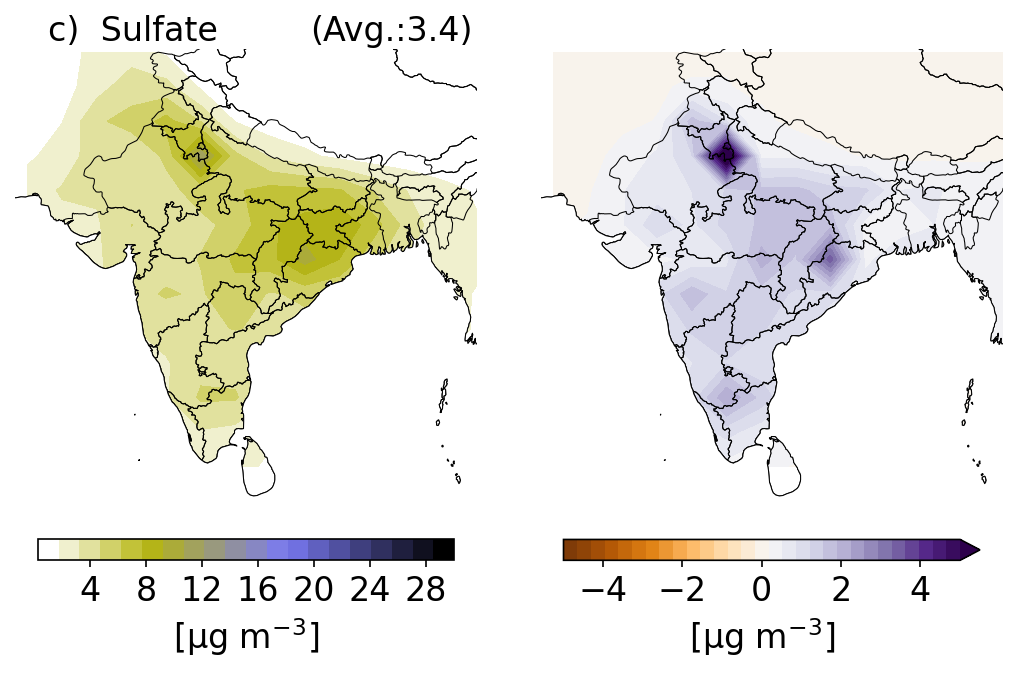

In [25]:
# Assuming 'calcs', 'cmap_ol_pu_bk', 'month_labs', 'city_lat_lons', etc., are pre-defined in your environment.

fig, axs = plt.subplots(1, 2, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(9, 5))

# Plot 1: SNEII surface map
ax = axs[0]
fg1 = calcs['SNEII'].SO4_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=30,
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 30,4))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())

ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

plt.text(33,35.5,f'c)  Sulfate')
plt.text(50,35.5,f"(Avg.:{calcs['SNEII'].SO4_india_land_mean.mean():.1f})")

# Plot 2: Difference map
ax = axs[1]
fg2 = calcs['diff'].SO4_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=5, vmin=-5, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-4, 5, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


plt.subplots_adjust(wspace=0.01)
# Final adjustments
#plt.tight_layout()
#plt.show()

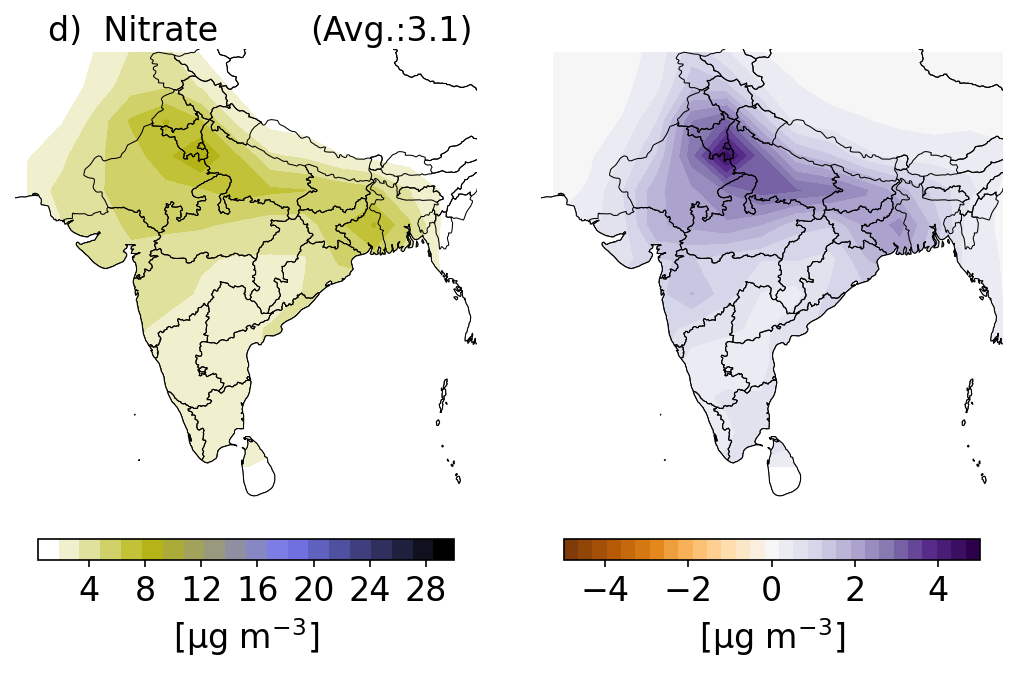

In [26]:
# Assuming 'calcs', 'cmap_ol_pu_bk', 'month_labs', 'city_lat_lons', etc., are pre-defined in your environment.

fig, axs = plt.subplots(1, 2, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(9, 5))

# Plot 1: SNEII surface map
ax = axs[0]
fg1 = calcs['SNEII'].NO3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=30,
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 30,4))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())

ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

plt.text(33,35.5,f'd)  Nitrate')
plt.text(50,35.5,f"(Avg.:{calcs['SNEII'].NO3_india_land_mean.mean():.1f})")

# Plot 2: Difference map
ax = axs[1]
fg2 = calcs['diff'].NO3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=5, vmin=-5, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-4, 5, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


plt.subplots_adjust(wspace=0.01)
# Final adjustments
#plt.tight_layout()
#plt.show()

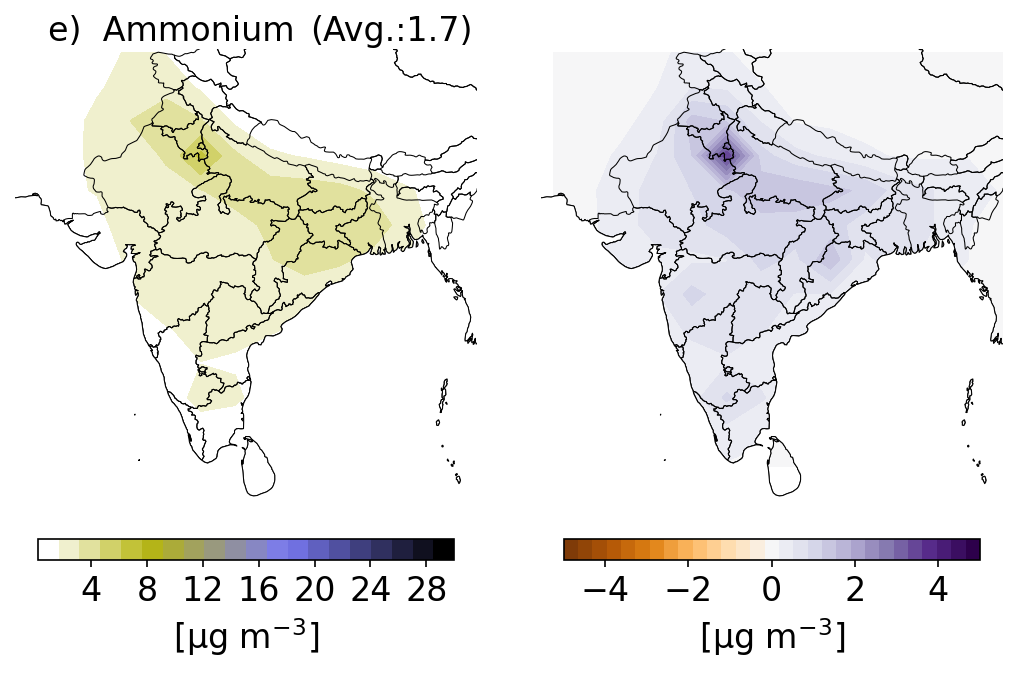

In [27]:
fig, axs = plt.subplots(1, 2, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(9, 5))

# Plot 1: SNEII surface map
ax = axs[0]
fg1 = calcs['SNEII'].NH4_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=30,
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 30,4))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())

ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

plt.text(33,35.5,f'e)  Ammonium')
plt.text(50,35.5,f"(Avg.:{calcs['SNEII'].NH4_india_land_mean.mean():.1f})")

# Plot 2: Difference map
ax = axs[1]
fg2 = calcs['diff'].NH4_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=5, vmin=-5, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-4, 5, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


plt.subplots_adjust(wspace=0.01)
# Final adjustments
#plt.tight_layout()
#plt.show()

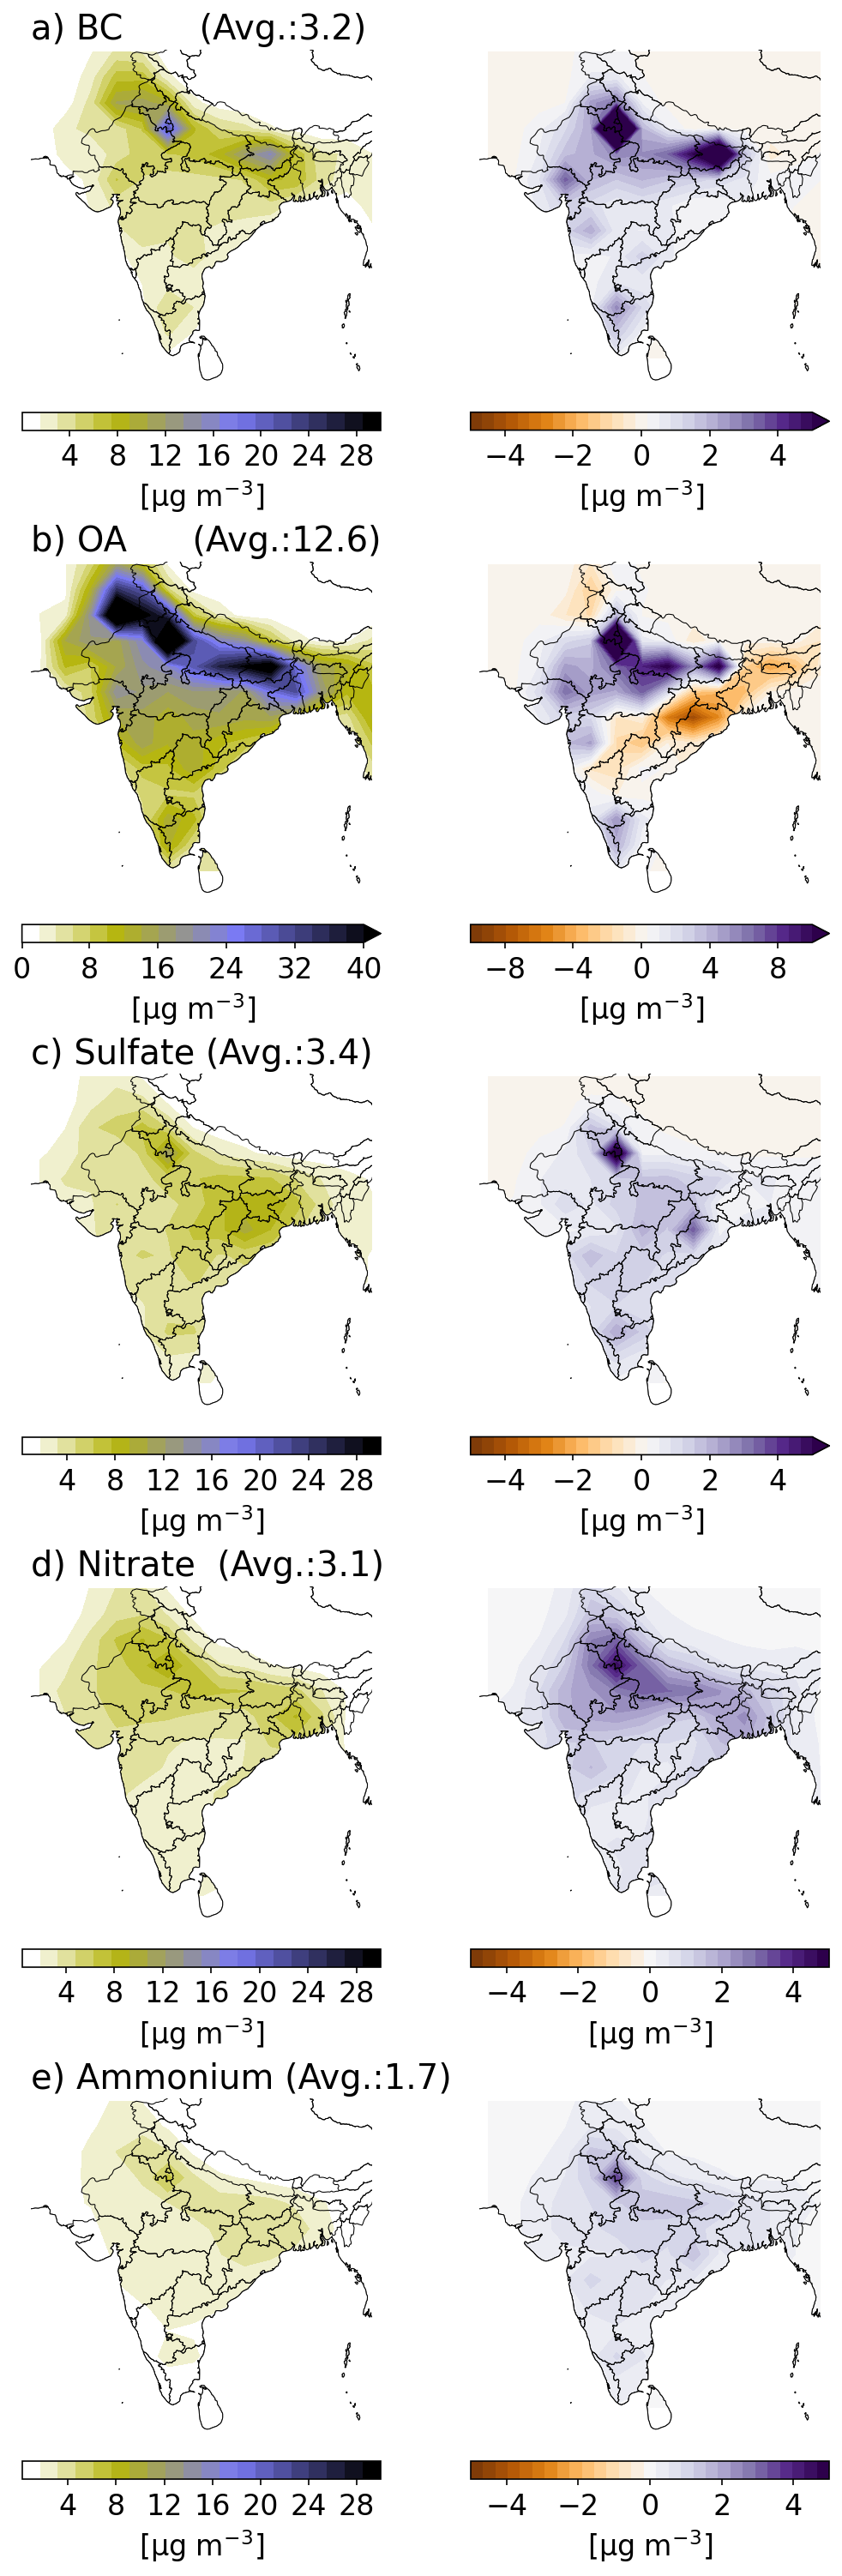

In [28]:
fig, axs = plt.subplots(5, 2, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(9, 25))

# BC
ax = axs[0,0]
fg1 = calcs['SNEII'].BC_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=30, 
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 30,4))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())

ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title('')
ax.set_title(f"a) BC       (Avg.:{calcs['SNEII'].BC_india_land_mean.mean():.1f})", loc='left')
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


# Plot 2: Difference map
ax = axs[0,1]
fg2 = calcs['diff'].BC_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=5, vmin=-5, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-4, 5, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

# POA
ax = axs[1,0]
fg1 = calcs['SNEII'].OA_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=40, 
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 41,8))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_title('')
ax.set_title(f"b) OA      (Avg.:{calcs['SNEII'].POA_india_land_mean.mean():.1f})", loc='left')
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


# Plot 2: Difference map
ax = axs[1,1]
fg2 = calcs['diff'].OA_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=10, vmin=-10, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-8, 11, 4))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

# SO4
ax = axs[2,0]
fg1 = calcs['SNEII'].SO4_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=30,
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 30,4))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_title('')
ax.set_title(f"c) Sulfate (Avg.:{calcs['SNEII'].SO4_india_land_mean.mean():.1f})", loc='left')
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

#plt.text(33,35.5,f'c)  Sulfate')
#plt.text(50,35.5,f"(Avg.:{calcs['SNEII'].SO4_india_land_mean.mean():.1f})")

# Plot 2: Difference map
ax = axs[2,1]
fg2 = calcs['diff'].SO4_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=5, vmin=-5, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-4, 5, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

# NO3
ax = axs[3,0]
fg1 = calcs['SNEII'].NO3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=30,
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 30,4))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_title('')
ax.set_title(f"d) Nitrate  (Avg.:{calcs['SNEII'].NO3_india_land_mean.mean():.1f})", loc='left')
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

#plt.text(33,35.5,f'd)  Nitrate')
#plt.text(50,35.5,f"(Avg.:{calcs['SNEII'].NO3_india_land_mean.mean():.1f})")

# Plot 2: Difference map
ax = axs[3,1]
fg2 = calcs['diff'].NO3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=5, vmin=-5, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-4, 5, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

# Ammonium
ax = axs[4,0]
fg1 = calcs['SNEII'].NH4_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=30,
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 30,4))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_title('')
ax.set_title(f"e) Ammonium (Avg.:{calcs['SNEII'].NH4_india_land_mean.mean():.1f})", loc='left')
#ax.set_title(f"(Avg.:{calcs['SNEII'].NH4_india_land_mean.mean():.1f})", loc='right')
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
#ax.set_title(f"e)  Ammonium (Avg.:{calcs['SNEII'].NH4_india_land_mean.mean():.1f})")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


# Plot 2: Difference map
ax = axs[4,1]
fg2 = calcs['diff'].NH4_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=5, vmin=-5, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-4, 5, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title('')
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


plt.subplots_adjust(wspace=0.0,hspace=0.2)

In [29]:
vars = ['BC', 'OA', 'SO4','NO3','NH4']
for n,var in enumerate(vars):
    print(var)
    print(n)

BC
0
OA
1
SO4
2
NO3
3
NH4
4


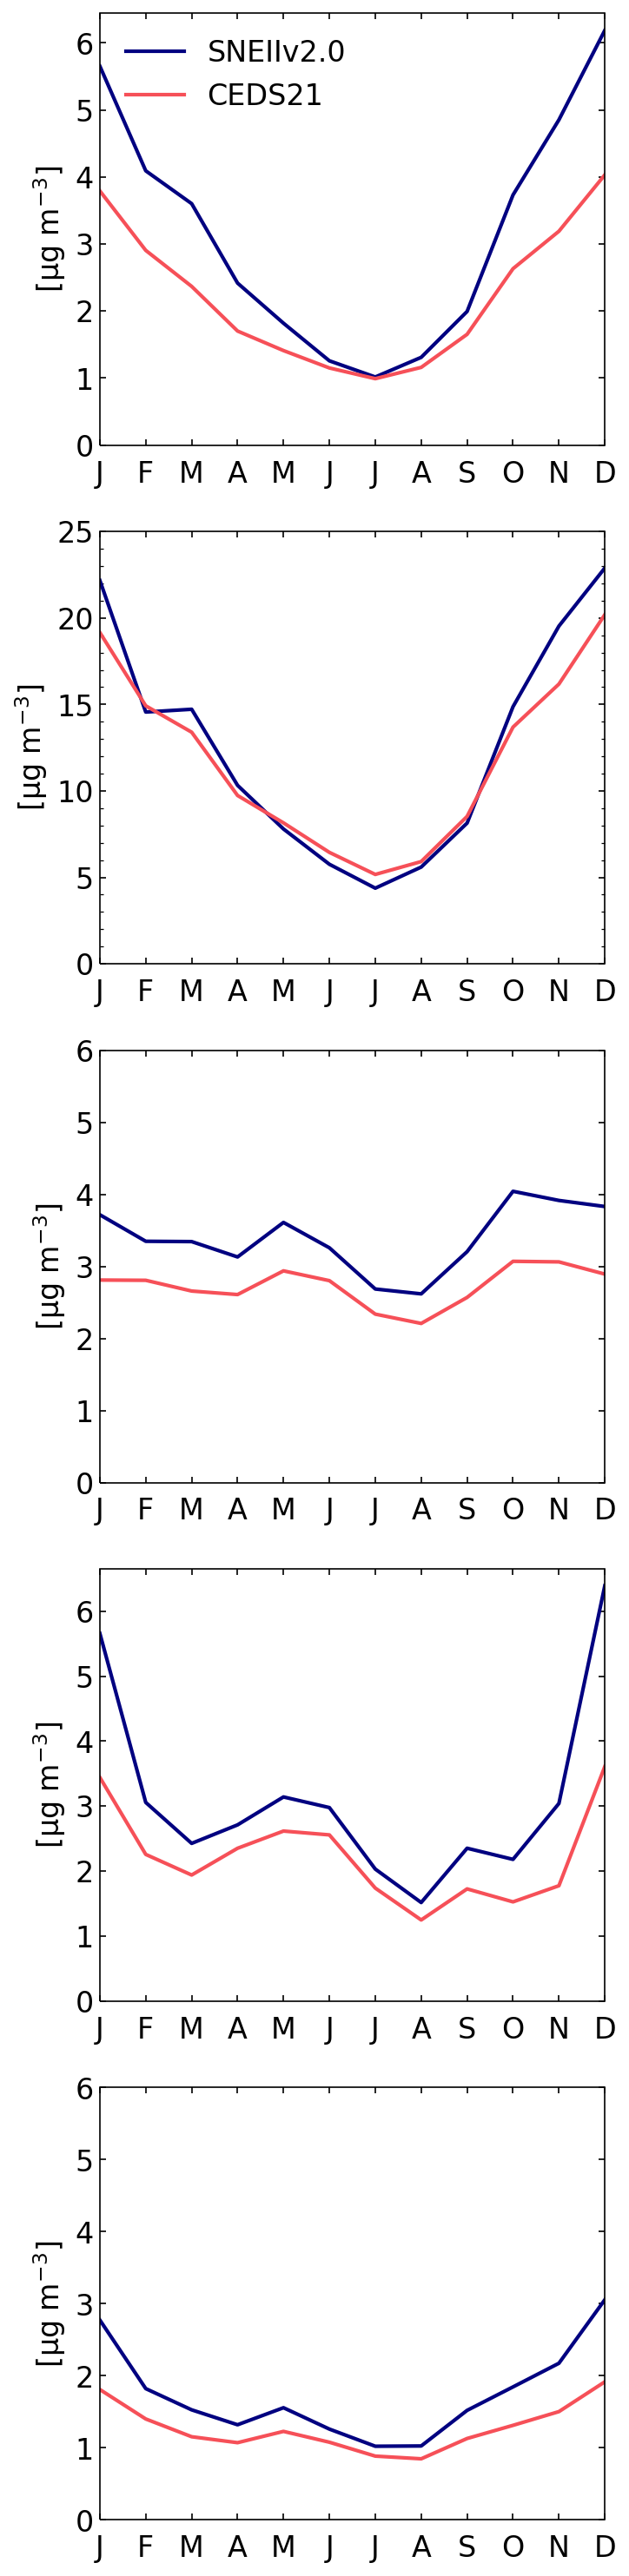

In [30]:
fig, axs = plt.subplots(5, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(5, 25))
vars = ['BC', 'POA', 'SO4','NO3','NH4']

for n,var in enumerate(vars):
    var_lab = f'{var}_india_land_mean'

    ax = axs[n]
    calcs['SNEII'][var_lab].plot(ax=ax, label = 'SNEIIv2.0', c= (0,0,128/255),linewidth=2)
    calcs['CEDS'][var_lab].plot(ax=ax, label = 'CEDS21', c=(246/255,80/255,88/255),linewidth=2)

    # chart formatting
    ax.set_xlim(0,11)
    ax.set_xticks(calcs['CEDS'].BC_india_land_mean.time.data)
    ax.set_xticklabels(month_labs)
    ax.set_xlabel('')
    ax.set_ylabel(r"[μg m$^{{-3}}$]")
    ax.set_title('')
    ax.set_yticks(np.arange(0,7,1))
    #leg = plt.legend(frameon=False,loc=2)
    ax.xaxis.set_tick_params(direction='in', which='both',top=True,pad=8)
    ax.yaxis.set_tick_params(direction='in', which='both',right=True)
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.set_aspect('auto')
    if n == 1:
        ax.set_yticks(np.arange(0,26,5))
    
    if n == 0:
        ax.legend(frameon=False, loc='upper left')

plt.subplots_adjust(hspace=0.2)

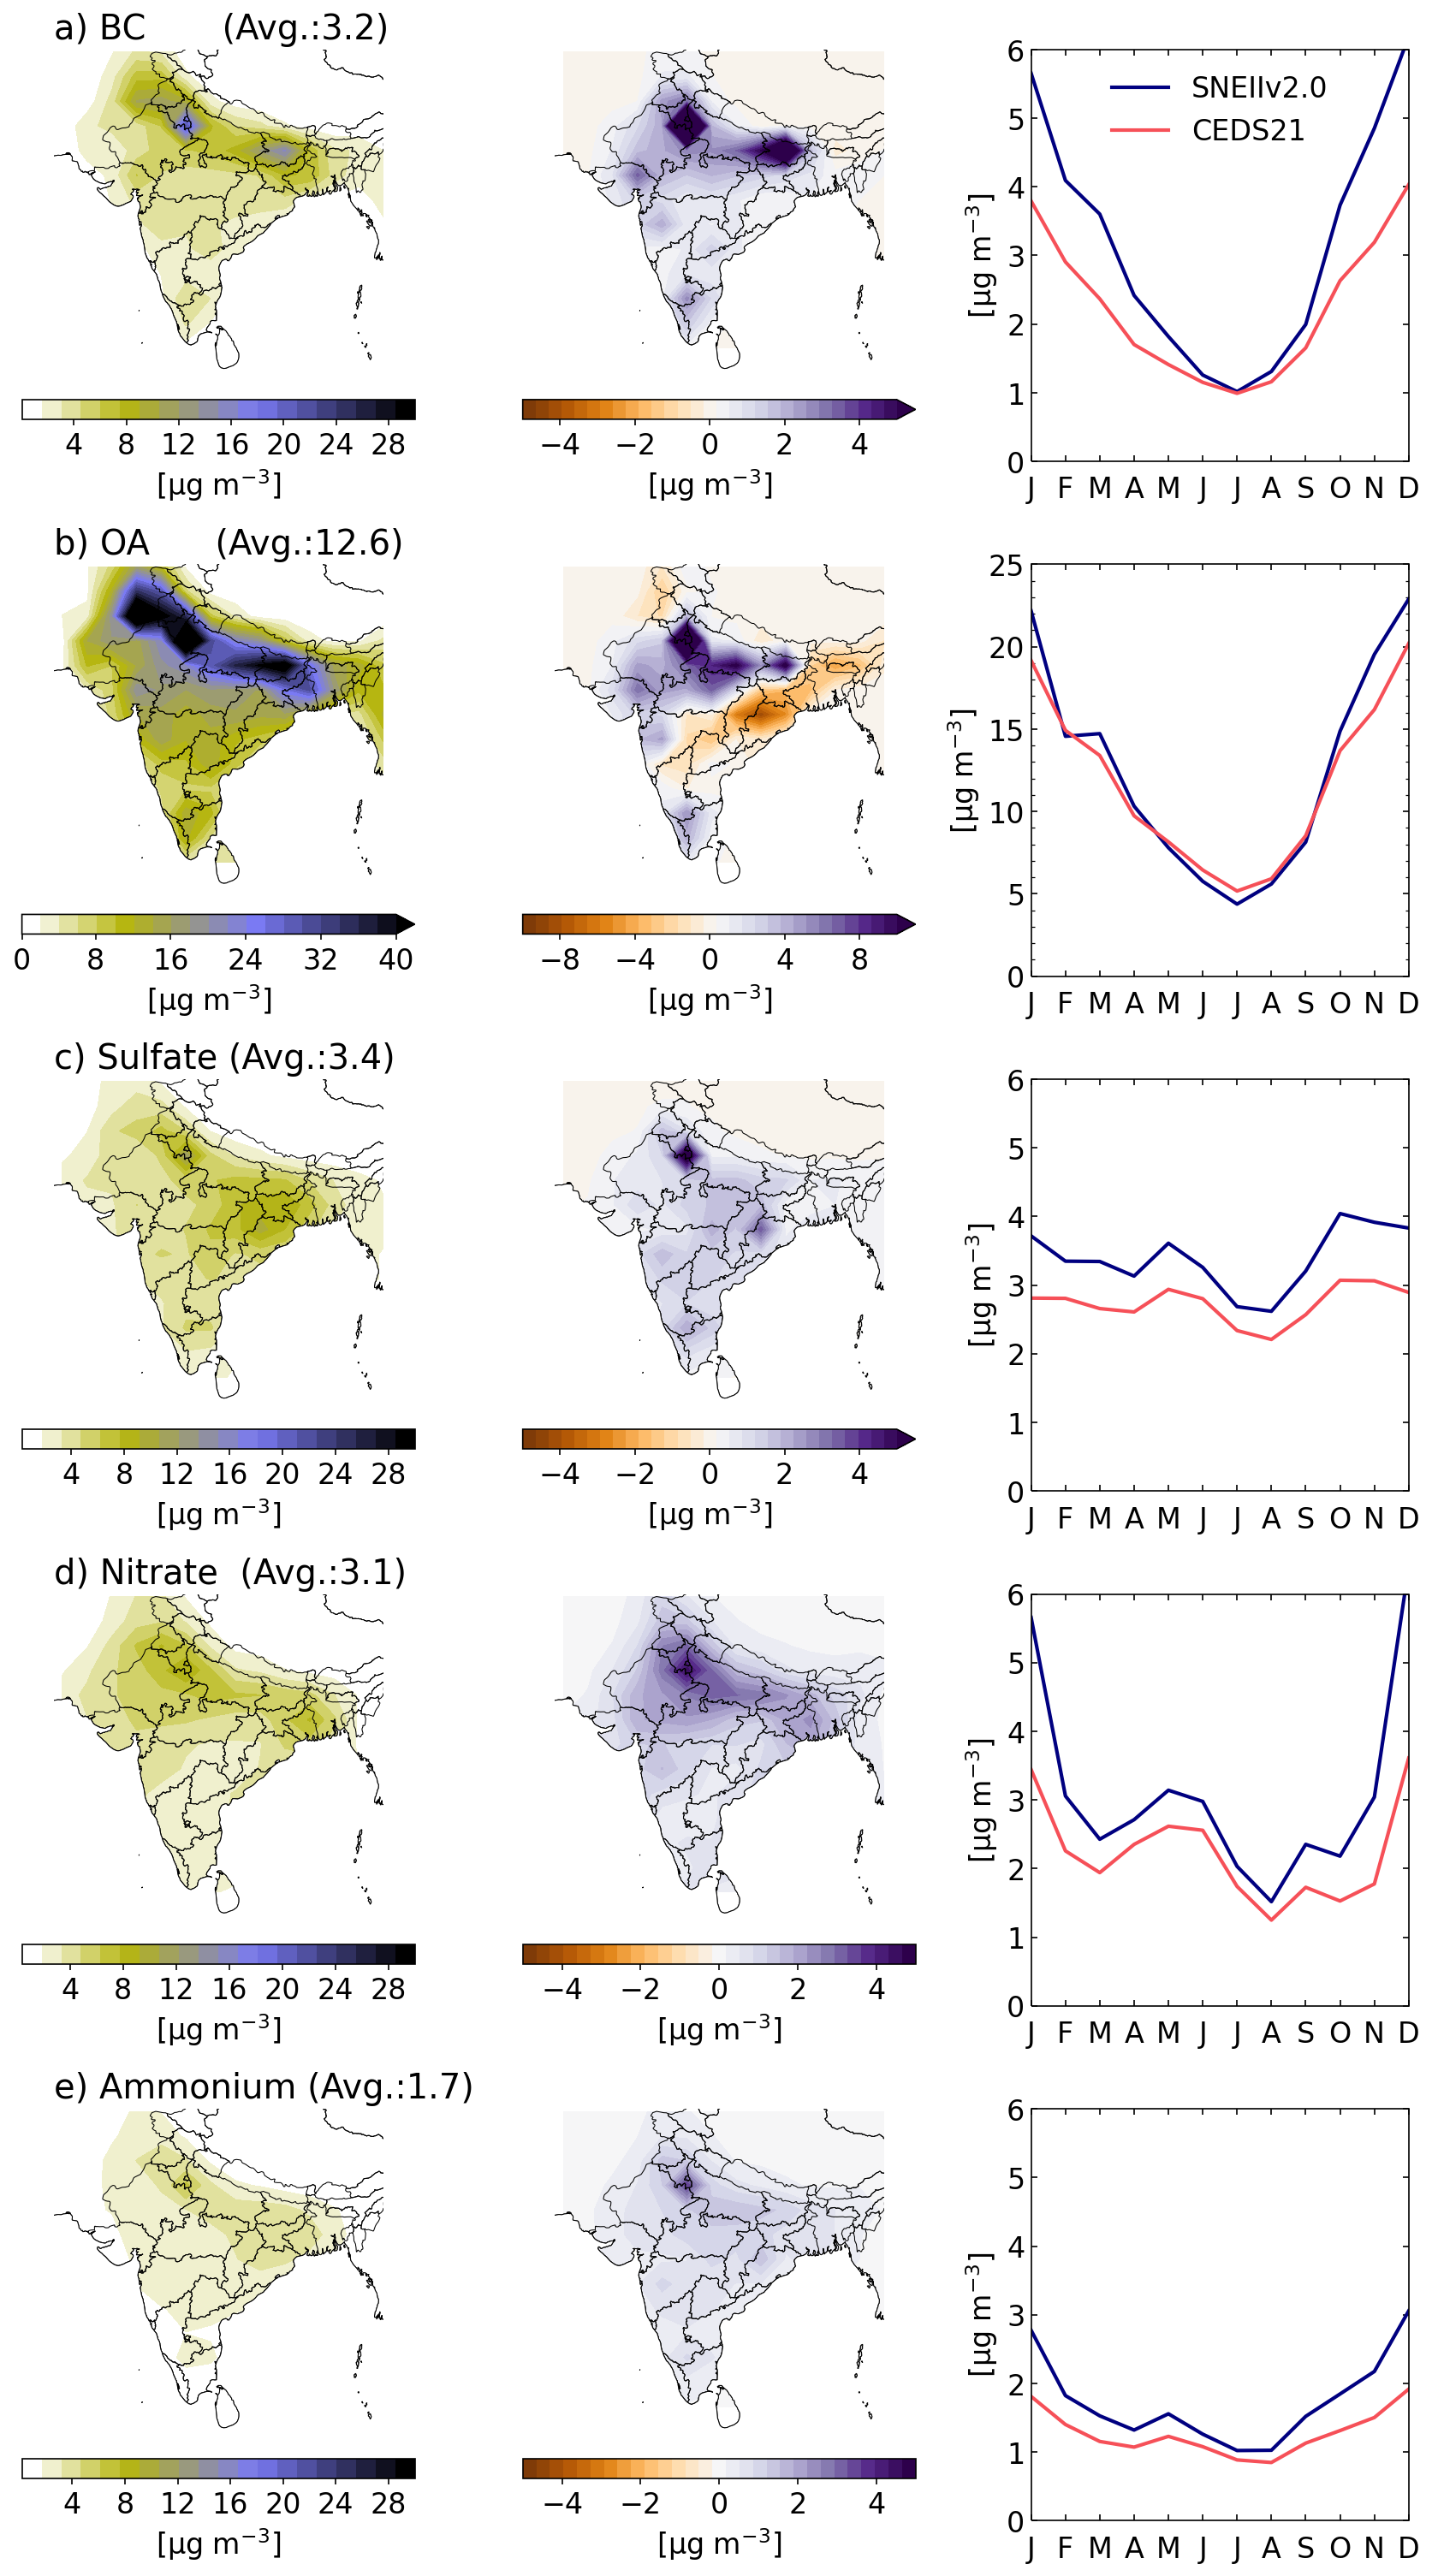

In [31]:
fig, axs = plt.subplots(5, 3, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(15, 25))

# BC
ax = axs[0,0]
fg1 = calcs['SNEII'].BC_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=30, 
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 30,4))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())

ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title('')
ax.set_title(f"a) BC       (Avg.:{calcs['SNEII'].BC_india_land_mean.mean():.1f})", loc='left')
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


# Plot 2: Difference map
ax = axs[0,1]
fg2 = calcs['diff'].BC_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=5, vmin=-5, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-4, 5, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

# POA
ax = axs[1,0]
fg1 = calcs['SNEII'].OA_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=40, 
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 41,8))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_title('')
ax.set_title(f"b) OA      (Avg.:{calcs['SNEII'].POA_india_land_mean.mean():.1f})", loc='left')
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


# Plot 2: Difference map
ax = axs[1,1]
fg2 = calcs['diff'].OA_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=10, vmin=-10, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-8, 11, 4))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

# SO4
ax = axs[2,0]
fg1 = calcs['SNEII'].SO4_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=30,
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 30,4))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_title('')
ax.set_title(f"c) Sulfate (Avg.:{calcs['SNEII'].SO4_india_land_mean.mean():.1f})", loc='left')
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

#plt.text(33,35.5,f'c)  Sulfate')
#plt.text(50,35.5,f"(Avg.:{calcs['SNEII'].SO4_india_land_mean.mean():.1f})")

# Plot 2: Difference map
ax = axs[2,1]
fg2 = calcs['diff'].SO4_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=5, vmin=-5, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-4, 5, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

# NO3
ax = axs[3,0]
fg1 = calcs['SNEII'].NO3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=30,
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 30,4))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_title('')
ax.set_title(f"d) Nitrate  (Avg.:{calcs['SNEII'].NO3_india_land_mean.mean():.1f})", loc='left')
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

#plt.text(33,35.5,f'd)  Nitrate')
#plt.text(50,35.5,f"(Avg.:{calcs['SNEII'].NO3_india_land_mean.mean():.1f})")

# Plot 2: Difference map
ax = axs[3,1]
fg2 = calcs['diff'].NO3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=5, vmin=-5, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-4, 5, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

# Ammonium
ax = axs[4,0]
fg1 = calcs['SNEII'].NH4_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=30,
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 30,4))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_title('')
ax.set_title(f"e) Ammonium (Avg.:{calcs['SNEII'].NH4_india_land_mean.mean():.1f})", loc='left')
#ax.set_title(f"(Avg.:{calcs['SNEII'].NH4_india_land_mean.mean():.1f})", loc='right')
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
#ax.set_title(f"e)  Ammonium (Avg.:{calcs['SNEII'].NH4_india_land_mean.mean():.1f})")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


# Plot 2: Difference map
ax = axs[4,1]
fg2 = calcs['diff'].NH4_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=5, vmin=-5, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-4, 5, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title('')
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


vars = ['BC', 'POA', 'SO4','NO3','NH4']

for n,var in enumerate(vars):
    var_lab = f'{var}_india_land_mean'

    ax = axs[n,2]
    calcs['SNEII'][var_lab].plot(ax=ax, label = 'SNEIIv2.0', c= (0,0,128/255),linewidth=2)
    calcs['CEDS'][var_lab].plot(ax=ax, label = 'CEDS21', c=(246/255,80/255,88/255),linewidth=2)

    # chart formatting
    ax.set_xlim(0,11)
    ax.set_ylim(0,6)
    ax.set_xticks(calcs['CEDS'].BC_india_land_mean.time.data)
    ax.set_xticklabels(month_labs)
    ax.set_xlabel('')
    ax.set_ylabel(r"[μg m$^{{-3}}$]")
    ax.set_title('')
    ax.set_yticks(np.arange(0,7,1))
    #leg = plt.legend(frameon=False,loc=2)
    ax.xaxis.set_tick_params(direction='in', which='both',top=True,pad=8)
    ax.yaxis.set_tick_params(direction='in', which='both',right=True)
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.set_aspect(2)
    if n == 1:
        ax.set_yticks(np.arange(0,26,5))
        ax.set_aspect(0.48)
    
    if n == 0:
        ax.legend(frameon=False)


plt.subplots_adjust(wspace=0.02,hspace=0.25)
plt.savefig(f'{outfile}Fig1_aerosols_surf_SNEII_diff_landmean.pdf',format='pdf',bbox_inches='tight')

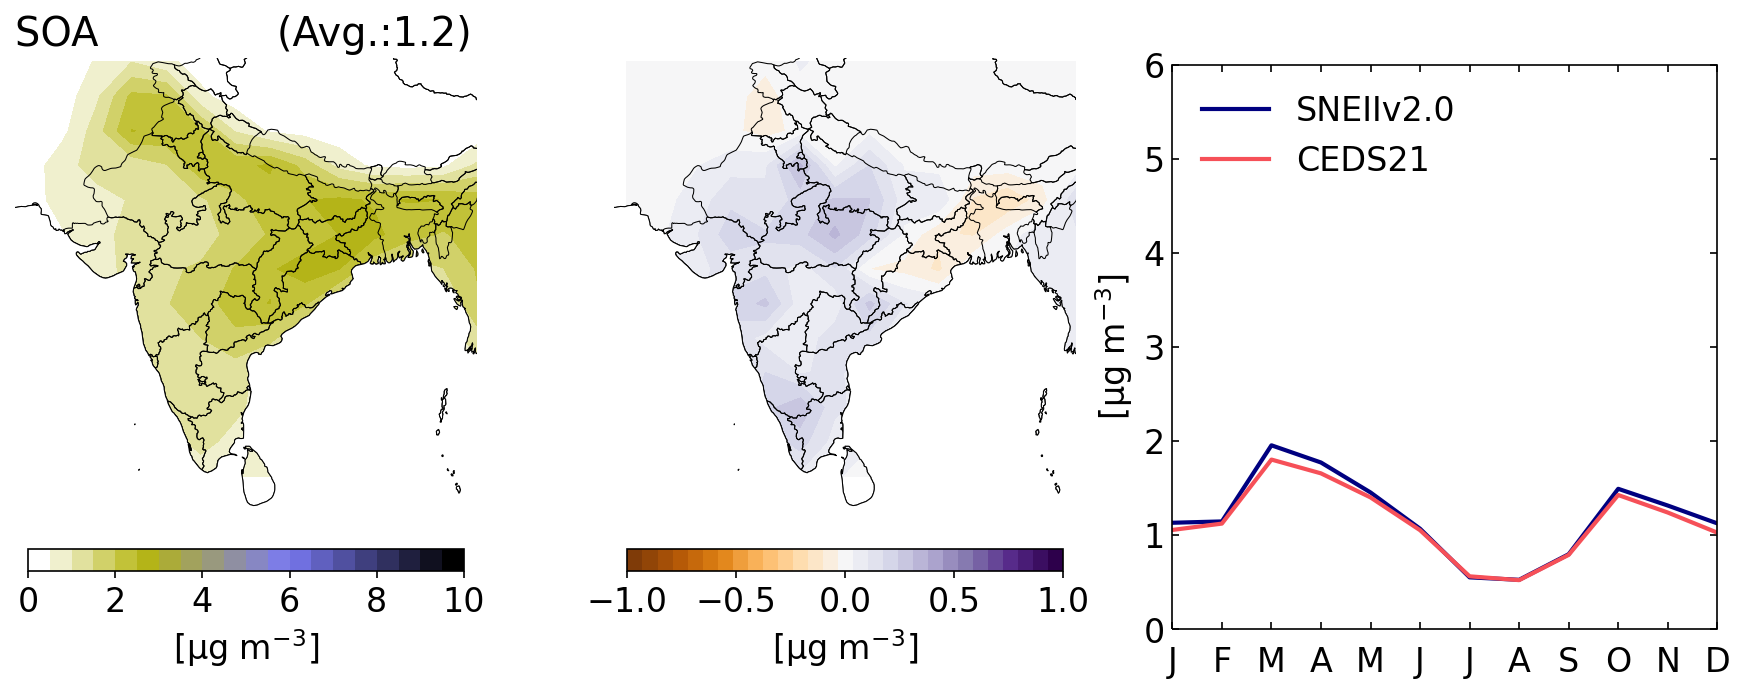

In [32]:
fig, axs = plt.subplots(1, 3, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(15, 5))


# Ammonium
ax = axs[0]
fg1 = calcs['SNEII'].SOA_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=10,vmin=0,
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 11,2))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_title('')
ax.set_title(f"SOA              (Avg.:{calcs['SNEII'].SOA_india_land_mean.mean():.1f})", loc='left')
#ax.set_title(f"(Avg.:{calcs['SNEII'].NH4_india_land_mean.mean():.1f})", loc='right')
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
#ax.set_title(f"e)  Ammonium (Avg.:{calcs['SNEII'].NH4_india_land_mean.mean():.1f})")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


# Plot 2: Difference map
ax = axs[1]
fg2 = calcs['diff'].SOA_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=1, vmin=-1, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-1, 1.1, 0.5))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title('')
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

ax = axs[2]
calcs['SNEII'].SOA_india_land_mean.plot(ax=ax, label = 'SNEIIv2.0', c= (0,0,128/255),linewidth=2)
calcs['CEDS'].SOA_india_land_mean.plot(ax=ax, label = 'CEDS21', c=(246/255,80/255,88/255),linewidth=2)

# chart formatting
ax.set_xlim(0,11)
ax.set_ylim(0,6)
ax.set_xticks(calcs['CEDS'].BC_india_land_mean.time.data)
ax.set_xticklabels(month_labs)
ax.set_xlabel('')
ax.set_ylabel(r"[μg m$^{{-3}}$]")
ax.set_title('')
ax.set_yticks(np.arange(0,7,1))
leg = plt.legend(frameon=False,loc=2)
ax.xaxis.set_tick_params(direction='in', which='both',top=True,pad=8)
ax.yaxis.set_tick_params(direction='in', which='both',right=True)
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_aspect(1.9)
vars = ['SOA']
#plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
#plt.savefig(f'{outfile}Fig1_aerosols_surf_SNEII_diff_landmean.pdf',format='pdf',bbox_inches='tight')